Transformer及其衍生架构，在自然语言处理上取得了卓越的成果。但是，在将这一范式迁移到时间序列预测上来的时候，却遇到了尴尬的打不过线性模型的困难

首先我们分析一下，NLP（自然语言处理）和TSF（时间序列预测）两个问题的主要差别：

1. 自然语言中的语义既存在在每个单词中，也存在在单词之间的序列关系上。一个句子完全打乱单词顺序，也能保留部分信息（尽管不那么准确）。一个还不懂语法的语言学习者，仅靠单词也可以和其他人勉强交流。但是对于时间序列，打乱顺序就意味着完全丢失信息，可以说时间序列的信息绝大部分都隐藏在序列之中。

2. 自然语言的具有高度的一致性和可迁移性，常见单词和词组的含义在绝大多数语料中都是相近相似的，虽然会有一些多义词但毕竟是少数。而不同的时间序列即使出现了相同的形态，也不能说就有相似含义。例如，在金融领域，某些价格形态会包含价格趋势信息，其底层的逻辑是多空双方的博弈导致的，但是如果这样的形态出现在例如气温序列中，就不能说表示趋势性，因为底层的逻辑完全不一样。

3. 自然语言的训练集非常丰富，在人类历史上积累了大量的训练语料。但由于时间序列的含义差距，每个领域的时间序列是有限的，只能使用当前研究的框架内的数据。一般资产的数据有10年以上已经是非常丰富的历史了。如果扩展序列就会面临结构和范式的变化。

4. 自然语言的模式迁移非常缓慢，几乎可以忽略不记，虽然人类的语言会有所发展和变化，但是这种变化都是以数十年为单位的，在短期内改变的只会有少数词的词义，大的语法是不会改变的。但对于金融数据。概念漂移是非常常见的，时间序列的底层因素，例如次贷危机、疫情的出现很可能直接导致资产的模式完全改变，从而让历史数据的价值大打折扣，进一步加剧了数据量的问题。

Transformer架构能在NLP上取得成功的原因，恰恰也是Transformer架构不能被直接迁移到TSF上的原因：

1. RNN架构的顺序结构会影响长距离信息传递，长距离信息要么随着梯度消失，要么产生梯度爆炸。为了能顺利捕捉长距离关系，Transformer架构可以放弃了RNN架构的顺序性，转而使用并行性保护远距离信息可以顺利传播；

2. 因为采用了并行架构丢失了顺序信息，Transformer架构采用位置编码补齐丢失的顺序信息。但位置编码会影响一部分原始语义信息；

3. 因为训练语料足够丰富，导致位置编码的影响可以被最小化；

4. 平行架构也可以充分运用算力，大幅度加速训练过程，因此可以接受更复杂的模型层数。将牺牲的部分通过更大的模型来弥补。

换言之，因为自然语言的训练资料足够丰富，足以掩盖Transformer架构的缺点，充分发挥Transformer架构的优势，才使得Transformer架构得以在NLP问题上大放异彩。但反过来，在TSF问题上，Transformer架构并没有这样的优势。而其劣势，会被时间序列数据量缺乏的问题放大。Transformer架构本身就很复杂，模型的参数量越大，需要的数据集也就越大，超大的模型可以轻松记忆本就为数不多的数据集导致过拟合，必须对扩展模型保持谨慎态度。

当然，这也并不意味着完全就不能使用Transformer架构。Transformer架构在长距离提取上仍然有优势。具体来说，如果想要充分发挥Transformer架构的优势，我们需要解决如下问题：

1. 每个信息单元包含的信息要足够丰富。自然语言中每个单词的语义已经非常丰富，最新的的大语言模型单个词嵌入维度已经达到了4096甚至更高。而单个时间步的OHLCV数据的维度太小，即使扩展一些辅助信息，也很难从单个时间步得到有效信息进行相互传播。因此，单个信息单元要从时间步提升到子序列级别，比如一个长达10天的子序列，除了10天本身的价格信息以外，还能抽象出某种趋势信息，例如一小段缩量上涨、或者一小段区间的放量震荡等等。通过将多个时间步组合成一个patch的方式，模型可以变为处理一段一段的时间。同时，这样的结构也可以接入更长的历史窗口，绕开Transformer在注意力层的O(N^2)复杂度的限制。

2. 用科学的方式扩展训练集，如果我们的目标是资产价格预测，那么至少训练集的范围可以扩展到其他金融资产，但不应该扩展到非金融的领域。因为价格的底层逻辑是供需关系、多空博弈。同时，还要增加额外的机制让模型理解不同资产之间的差距和联系，例如波动率、相关性、协整性等等。



In [23]:
import os
os.chdir('d:/future/Index_Future_Prediction')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import lr_scheduler, Adam, AdamW
from torch.utils.data import TensorDataset, DataLoader

from utils import *

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [24]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    """
    处理(* , seq_len, feature_dim) tensor，在seq_len维度上添加位置编码。
    """
    def __init__(self, d_model, dropout, max_len = 5000):
        """
            d_model (int): 特征维度 (feature_dim)
            dropout (float): Dropout的概率
            max_len (int): 预先计算编码的最大序列长度
        """
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        assert d_model % 2 == 0, "d_model 必须是偶数"

        position = torch.arange(max_len).unsqueeze(1)


        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe)

    def forward(self, x):
        seq_len = x.size(-2)
        pos_encoding = self.pe[:seq_len, :]
        x = x + pos_encoding
        return self.dropout(x)

In [25]:
class PatchProjection(nn.Module):
    def __init__(self, input_size, patch_size, d_model = 128, dropout = 0.1):
        super().__init__()
        self.input_size = input_size
        self.patch_size = patch_size
        
        self.project = nn.Linear(input_size * patch_size, d_model) # 暂时只使用单层线性投影就够了 暂时不需要做太过深度的信息抽象，这个过程会交给Encoder去完成
        self.pe = PositionalEncoding(d_model = d_model, dropout = dropout)
        
    
    def forward(self, x):
        x = self.project(x)
        x = self.pe(x)
        return x

x = torch.randn(size = (64, 100))
pp = PatchProjection(input_size = 10, patch_size = 10, d_model = 128, dropout = 0.1)
pp(x).shape

torch.Size([64, 128])

In [26]:
from modules.patch import TimeSeriesPatcher
from modules.encoder import MultiLayerEncoder


class Patch_TST(nn.Module):
    """循环神经网络模型"""
    def __init__(self, input_size, seq_len, patch_size, stride, num_layer, num_head, d_model, masking_ratio, dropout_1, dropout_2, dropout_3):
        super().__init__()
        self.device = 'cuda:0'
        self.input_size = input_size
        self.patch_size = patch_size
        self.stride = stride
        self.masking_ratio = masking_ratio

        self.num_patch = int(np.floor((seq_len - patch_size) / stride) + 1)

        self.patch = TimeSeriesPatcher(patch_size, stride) # 首先经过patcher分成子序列

        self.projection = PatchProjection(input_size, patch_size, d_model = d_model, dropout = dropout_1)

        self.encoder = MultiLayerEncoder(dim_feature = d_model, dim_sequence = self.num_patch, num_enc_layer = num_layer, num_head = num_head, num_ffn_hidden = d_model*2, dropout = dropout_2)

        self.reconstruction = nn.Linear(d_model, input_size * patch_size)
        
        self.output = nn.Sequential(
            nn.Flatten(start_dim = -2),
            nn.Dropout(dropout_3),
            HybridDecoder(dim_state = self.num_patch * d_model, init_prob = [0.0,0.5,0.0])
        )
    
    # 自监督学习
    def self_supervised(self, x):
        
        device = x.device
        batch_size = x.shape[0]
        noise = torch.rand(size = (batch_size, self.num_patch)).to(device)
        mask = noise < self.masking_ratio
        reshape_mask = mask.unsqueeze(-1)

        x_patched = self.patch(x)
        
        x_masked = torch.where(reshape_mask, 0.0, x_patched)
        x_projected = self.projection(x_masked)
        x_encodered = self.encoder(x_projected)
        x_pre_reconstruction = x_encodered[mask]
        x_reconstructed = self.reconstruction(x_pre_reconstruction)
        x_target = x_patched[mask]

        return x_reconstructed, x_target
    
    # 传播输出
    def forward(self, x):
        x_patched = self.patch(x)
        x_projected = self.projection(x_patched)
        x_encodered = self.encoder(x_projected)
        output = self.output(x_encodered)
        return output
        

# model = Patch_TST(input_size = 10, seq_len = 50, patch_size = 10, stride = 3,num_layer = 2, num_head = 8, d_model = 128, masking_ratio = 0.5, dropout_1 = 0.2, dropout_2 = 0.2, dropout_3 = 0.2)
# x = torch.randn(size = (64,50,10))
# x_reconstructed, x_raw = model.self_supervised(x)
# x_reconstructed.shape, x_raw.shape

In [27]:
# hyper parameter

seq_len = 50
patch_size = 10
stride = 3

num_layer = 2
num_head = 8
d_model = 128
masking_ratio = 0.5

dropout_1 = 0.2
dropout_2 = 0.2
dropout_3 = 0.3

batch_size = 128
learning_rate = 5e-3
weight_decay = 1e-5


In [ ]:
def objective(trial):
    # learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True) # 对数均匀分布
    # weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-1, log=True) # 对数均匀分布
    # dropout = trial.suggest_float("dropout", 0.2, 0.5)
    # batch_size = trial.suggest_categorical("batch_size", [64, 128, 256])
    # seq_len = trial.suggest_categorical("seq_len", [30, 60, 90])
    # hidden_size = trial.suggest_categorical('hidden_size', [10,15,20,30])
    # num_layers = trial.suggest_categorical('num_layers', [1,2,3])
    # patch_size = trial.suggest_categorical('patch_size', [5,10,20])
    # in_patch_hidden_size = trial.suggest_categorical('in_patch_hidden_size', [10,15,20,30])
    # in_patch_num_layers = trial.suggest_categorical('in_patch_num_layers', [1,2,3])
    # alpha = trial.suggest_float('alpha', 1e-2, 1e-1)

    seq_len = 50
    patch_size = 10
    stride = 3

    num_layer = 2
    num_head = 8
    d_model = 128
    masking_ratio = 0.5

    dropout_1 = 0.2
    dropout_2 = 0.2
    dropout_3 = 0.3

    batch_size = 128
    learning_rate = 5e-3
    weight_decay = 1e-5

    # 提取数据
    feature_columns = ['inday_chg_open','inday_chg_high','inday_chg_low','inday_chg_close','inday_chg_amplitude', 'ma_10','ma_26','ma_45','ma_90','ma_vol',]
    label_columns = ['label_return','down_prob','middle_prob','up_prob']
    assets_list = ['IH.CFX', 'IF.CFX', 'IC.CFX', 'AU.SHF', 'JM.DCE','RB.SHF','HC.SHF', 'I.DCE', 'M.DCE', 'CF.ZCE',]
    # assets_list = ['IH.CFX', 'IF.CFX', 'IC.CFX',]
    feature = []
    label = []

    for asset_code in assets_list:
        data = pd.read_csv(f'data/{asset_code}.csv')
        feature.append(torch.tensor(data[feature_columns].values, dtype = torch.float32, device = 'cuda:0'))
        label.append(torch.tensor(data[label_columns].values, dtype = torch.float32, device = 'cuda:0'))

    # 加载数据
    feature = torch.stack(feature, dim = 1)
    label = torch.stack(label, dim = 1)
    print(feature.shape, label.shape)

    # 折叠时间步
    feature = feature.unfold(dimension = 0, size = seq_len, step = 1).transpose(2,3)
    label = label[seq_len-1:]
    print(feature.shape, label.shape)

    data = RandomLoader(feature, label)
    train_loader, test_loader = data(batch_size=batch_size, slice_size=[0.5,0.4], balance=[True, False])

    loss_fn = nn.MSELoss()
    model = Patch_TST(input_size = 10,
                    seq_len = seq_len,
                    patch_size = patch_size,
                    stride = stride,
                    num_layer = num_layer, 
                    num_head = num_head,
                    d_model = d_model,
                    masking_ratio = masking_ratio,
                    dropout_1 = dropout_1,
                    dropout_2 = dropout_2,
                    dropout_3 = dropout_3,
                    ).to('cuda:0')

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay = weight_decay)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)


    def epoch():
        train_losses = []
        model.train()
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            x_reconstructed, x_target = model.self_supervised(batch_x)
            loss = loss_fn(x_reconstructed, x_target)
            train_losses.append(loss.item()) 
            loss.backward()
            optimizer.step()
        
        test_losses = []
        model.eval()
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                x_reconstructed, x_target = model.self_supervised(batch_x)
                loss = loss_fn(x_reconstructed, x_target)
                test_losses.append(loss.item()) 
        return np.mean(train_losses), np.mean(test_losses)

    def train(epochs = 100):
        train_losses = []
        test_losses = []
        for i in tqdm.tqdm(range(epochs)):
            train_loss, test_loss = epoch()
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            scheduler.step()

        
        # plt.plot(range(epochs), train_losses)
        # plt.plot(range(epochs), test_losses)
        # plt.show()


    return np.mean(precision_list)/np.std(precision_list)

In [35]:
# 提取数据
assets_list = ['IH.CFX', 'IF.CFX', 'IC.CFX', 'AU.SHF', 'JM.DCE','RB.SHF','HC.SHF', 'I.DCE', 'M.DCE', 'CF.ZCE',]
# assets_list = ['IH.CFX', 'IF.CFX', 'IC.CFX',]

feature_columns = ['inday_chg_open','inday_chg_high','inday_chg_low','inday_chg_close','inday_chg_amplitude', 'ma_10','ma_26','ma_45','ma_90','ma_vol',]
label_columns = ['label_return','down_prob','middle_prob','up_prob']

feature = []
label = []

for asset_code in assets_list:
    data = pd.read_csv(f'data/{asset_code}.csv')
    feature.append(torch.tensor(data[feature_columns].values, dtype = torch.float32, device = 'cuda:0'))
    label.append(torch.tensor(data[label_columns].values, dtype = torch.float32, device = 'cuda:0'))

# 加载数据
feature = torch.stack(feature, dim = 1)
label = torch.stack(label, dim = 1)
print(feature.shape, label.shape)

# 折叠时间步
feature = feature.unfold(dimension = 0, size = seq_len, step = 1).transpose(2,3)
label = label[seq_len-1:]
# 归并品种
feature = torch.flatten(feature, start_dim=0, end_dim = 1)
label = torch.flatten(label, start_dim=0, end_dim = 1)
print(feature.shape, label.shape)

data = RandomLoader(feature, label)

torch.Size([2603, 10, 10]) torch.Size([2603, 10, 4])
torch.Size([25540, 50, 10]) torch.Size([25540, 4])


In [32]:
train_loader, test_loader = data(batch_size=batch_size, slice_size=[0.5,0.4], balance=[True, False])
recorder = PredictionRecorder()
animator = TrainMonitor(figsize=(12,6))
loss_fn = nn.MSELoss()
model = Patch_TST(input_size = 10,
                  seq_len = seq_len,
                  patch_size = patch_size,
                  stride = stride,
                  num_layer = num_layer, 
                  num_head = num_head,
                  d_model = d_model,
                  masking_ratio = masking_ratio,
                  dropout_1 = dropout_1,
                  dropout_2 = dropout_2,
                  dropout_3 = dropout_3,
                  ).to('cuda:0')

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay = weight_decay)
scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)


def epoch():
    train_losses = []
    test_losses = []

    model.train()
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        x_reconstructed, x_target = model.self_supervised(batch_x)
        loss = loss_fn(x_reconstructed, x_target)
        train_losses.append(loss.item()) 
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            x_reconstructed, x_target = model.self_supervised(batch_x)
            loss = loss_fn(x_reconstructed, x_target)
            test_losses.append(loss.item())
            
    return np.mean(train_losses), np.mean(test_losses)

def train(epochs = 100):
    train_losses = []
    test_losses = []
    for i in tqdm.tqdm(range(epochs)):
        train_loss, test_loss = epoch()
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        scheduler.step()
    
    plt.plot(range(epochs), train_losses)
    plt.plot(range(epochs), test_losses)
    plt.show()

530


100%|██████████| 100/100 [00:40<00:00,  2.50it/s]


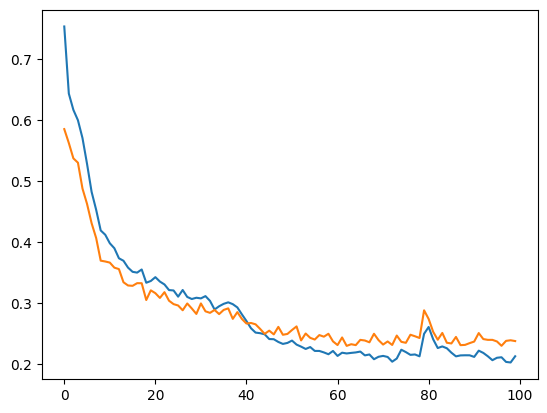

In [33]:
train(100)
torch.save(model.state_dict(), 'params/self_supervised.params')

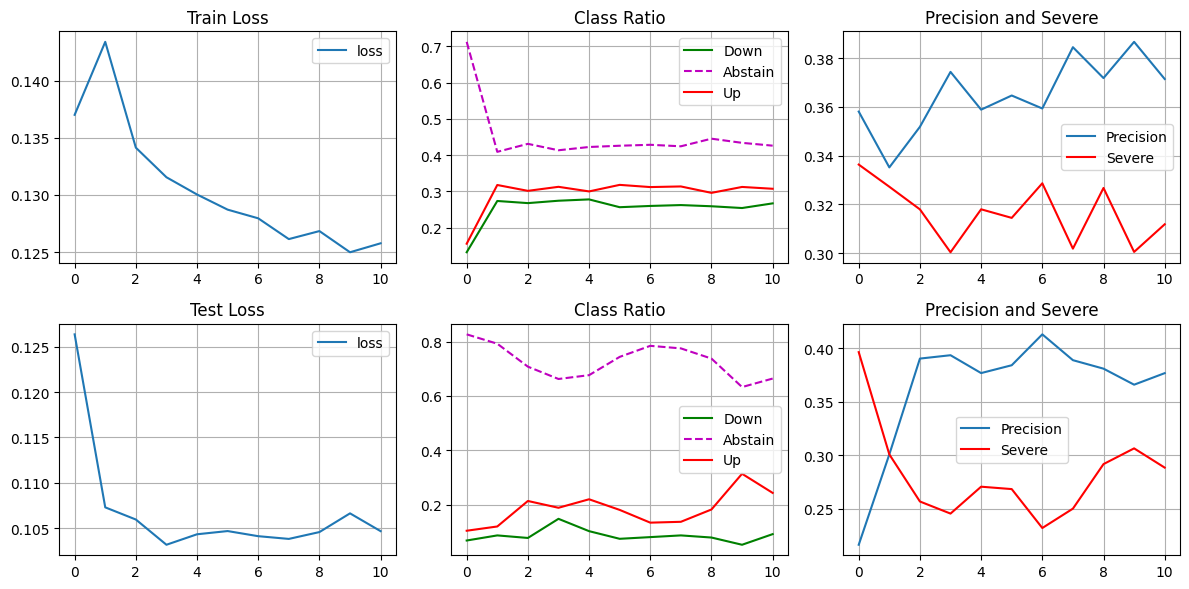

100%|██████████| 5/5 [00:00<00:00, 213.91it/s]


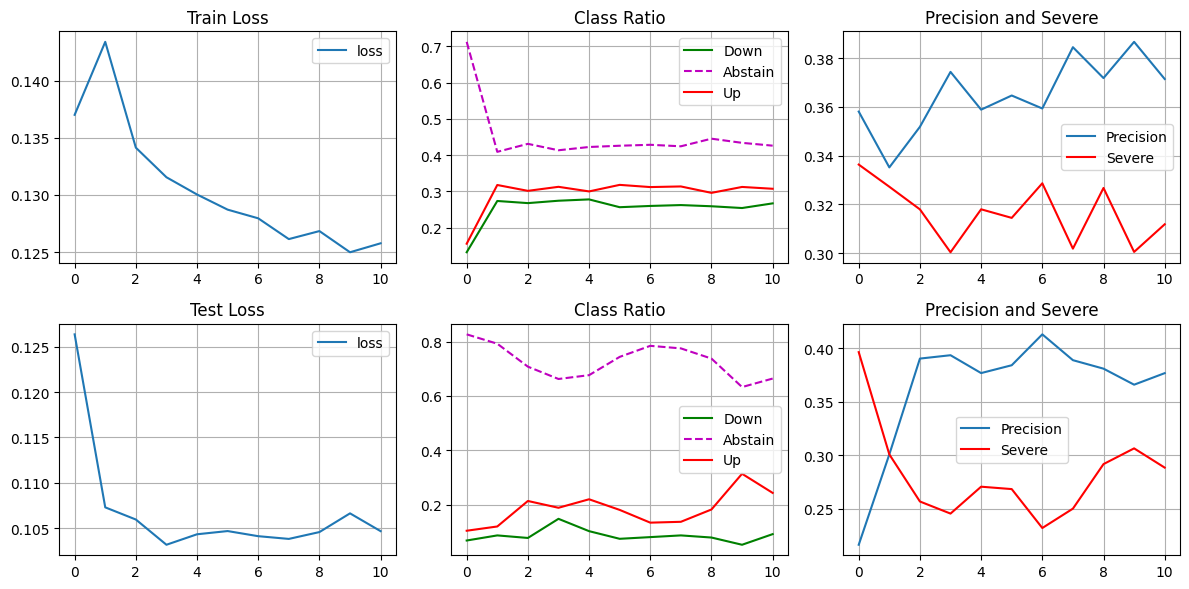

In [12]:
# 二阶段训练 设置较小学习率
learning_rate = 1e-4
weight_decay = 1e-4


j = len(assets_list)
result = np.zeros(shape = (10, 1, 4))

for i in range(10):
    j = 0

    train_loader, test_loader = data(batch_size=batch_size, slice_size=[0.6,0.1], balance=[True, False])
    
    animator.reset()
    loss_fn = HybridLoss(alpha = 1e-2, delta = 1.3, show_loss = False)

    model = Patch_TST(input_size = 10,
                  seq_len = seq_len,
                  patch_size = patch_size,
                  stride = stride,
                  num_layer = num_layer, 
                  num_head = num_head,
                  d_model = d_model,
                  masking_ratio = masking_ratio,
                  dropout_1 = dropout_1,
                  dropout_2 = dropout_2,
                  dropout_3 = dropout_3,
                  ).to('cuda:0')
    model.load_state_dict(torch.load('params/self_supervised.params'))
    
    optimizer = torch.optim.AdamW(model.output.parameters(), lr=learning_rate, weight_decay = weight_decay) # 只训练输出层
    
    scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
    train = ModelTrain(model = model,
                    train_loader = train_loader,
                    test_loader = test_loader,
                    loss_fn = loss_fn,
                    optimizer = optimizer,
                    scheduler = scheduler,
                    recorder = recorder,
                    graph = animator,
                    )
    prediction, precision = train.epoch_train(epochs = 10, early_stop = 100)

    result[i,j,0] = prediction
    result[i,j,1] = precision


In [13]:
all_assets = pd.DataFrame({
    'stage_1_prediction': np.mean(result, axis = 0)[:,0],
    'stage_2_prediction': np.mean(result, axis = 0)[:,2],

    'stage_1_precision': np.mean(result, axis = 0)[:,1],
    'stage_2_precision': np.mean(result, axis = 0)[:,3],

    'stage_1_precision_std': np.std(result, axis = 0)[:,1],
    'stage_2_precision_std': np.std(result, axis = 0)[:,3],
})
# all_assets.index = pd.Series(assets_list)
for col in all_assets.columns:
    all_assets[col] = all_assets[col].apply(lambda x: f"{x:.1%}")

# 转换为Markdown
markdown_table = all_assets.to_markdown(index=False)
print(markdown_table)

| stage_1_prediction   | stage_2_prediction   | stage_1_precision   | stage_2_precision   | stage_1_precision_std   | stage_2_precision_std   |
|:---------------------|:---------------------|:--------------------|:--------------------|:------------------------|:------------------------|
| 29.3%                | 0.0%                 | 13.3%               | 0.0%                | 10.5%                   | 0.0%                    |
